## Mean-Reverting Ratio: ESc1/VXc1

The source for the S&P 500/Volatility ratio is from the book Quantitative Trading by the author Ernie Chan. I would highly recommend this book to anyone interested in quantitative trading. The interpretation and application of the ratio are my own, as they apply it differently in the book, where they play the roll return and not the overbought/oversold market condition.

The majority of financial time-series are exhibiting a geometric random walk, hence why it is extremely challenging to predict the future. As a result, quantitative analysts can manufacture a mean-reverting price series to build a trading strategy that has the power of predicting the next price move based on the assumption that the price series will revert. 

Mean-reverting simply means that the change in the next price series is proportional to the difference in the current price and the mean price. For example, if the ratio of two instruments is stationary and cointegrated, then the probability of that ratio to revert to its mean when it reached an overbought or oversold level is exceptionally high. 

The objective of a quantitative signal is to systematically identify turning points in a price series when its ratio is stationary. The goal is not to predict precisely by how much it will revert, but that it will merely return.


##### Import Packages

In [90]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import PIL
from PIL import Image

##### Import App Key

In [91]:
import eikon as TR
TR.set_app_key('29e7c9361eb64e748246349dff7c07a532e1f41d')

##### Pull Price Close And Compute Ratio

The ESc1 represents the S&P 500 futures and the VXc1 is the Volatility VIX Futures.
Then, I computed a simple ratio from both time-series.

In [92]:
start_date = '2015-01-01'
end_date = '2020-06-05'
ES, e= TR.get_data(['ESv1'],['TR.closeprice.date','TR.closeprice'],
                       {'SDate':start_date,'EDate':end_date,'Frq':'D'})
VX, e= TR.get_data(['VXc1'],['TR.closeprice.date','TR.closeprice'],
                       {'SDate':start_date,'EDate':end_date,'Frq':'D'})

In [93]:
ES['Date'] = ES['Date'].apply(pd.to_datetime)
ES.set_index('Date', inplace=True)
ES = ES.dropna()
VX['Date'] = VX['Date'].apply(pd.to_datetime)
VX.set_index('Date', inplace=True)
VX = VX.dropna()

ES_VX = pd.merge(left=ES, right=VX, how='left', left_on=['Date'], right_on=['Date'])

In [94]:
ES_VX.groupby(['Date'])
ES_VX['ES/VX Ratio'] = ES_VX['Close Price_x']/ES_VX['Close Price_y']
ES_VX = ES_VX.round(2)
ES_VX = ES_VX.dropna()
ES_VX.head()

,Instrument_x,Close Price_x,Instrument_y,Close Price_y,ES/VX Ratio
Date,,,,,
2015-01-02 00:00:00+00:00,ESv1,2046.75,VXc1,17.85,114.66
2015-01-05 00:00:00+00:00,ESv1,2016.00,VXc1,19.11,105.49
2015-01-06 00:00:00+00:00,ESv1,1995.00,VXc1,19.85,100.50
2015-01-07 00:00:00+00:00,ESv1,2020.00,VXc1,18.83,107.28
2015-01-08 00:00:00+00:00,ESv1,2054.50,VXc1,17.70,116.07


In [95]:
ES_VX = ES_VX.loc[lambda d: d['ES/VX Ratio'] >= 0]

##### Plotting Data

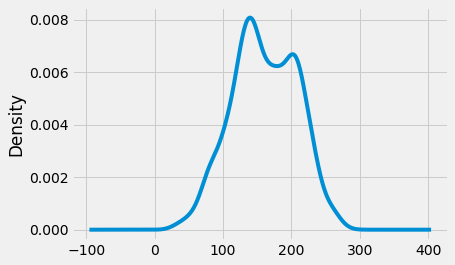

In [96]:
ES_VX['ES/VX Ratio'].plot(kind='density')

##### Augmented Dickey-Fuller Test

In [97]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(ES_VX['ES/VX Ratio'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.100712
p-value                           0.000966
#Lags Used                        0.000000
Number of Observations Used    1358.000000
Critical Value (1%)              -3.435175
Critical Value (5%)              -2.863671
Critical Value (10%)             -2.567904
dtype: float64


We can reject H0 and conclude that the ESc1/VXc1 is stationary at a 99% confidence level. The timeframe selected here will greatly impact our Augmented Dickey-Fuller test, where if select the period since 2005, we can only reject it at the 90% confidence level. 

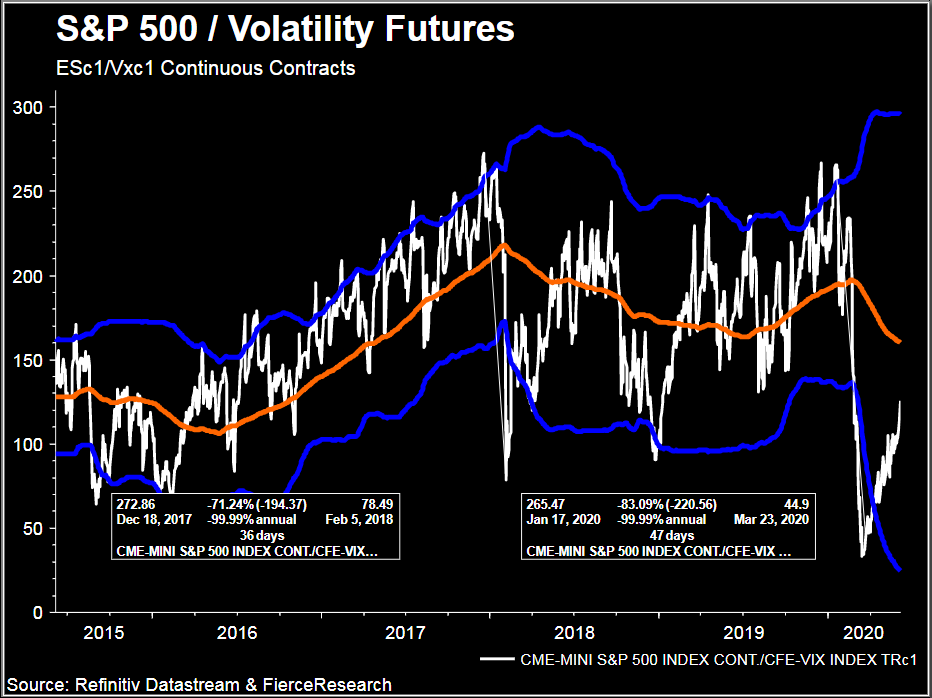

In [98]:
im = Image.open('ES_VX.PNG')
im

##### Trading Signal
When the ES/VX Ratio reaches above or below 2 standard deviations of a 200-day moving average, it gives a signal that a reversal is imminent. If the ratio closes below the lower band, it is time to buy equities and volatility is extremely stretched. If the ratio is above the higher band, it is time to buy volatility(i.e., insurance). At the same time, equity markets are stretched, and where the likelihood of the ratio reverting the 200-day moving average is high. As the saying goes: "When VIX is slow, go slow..."

As with any other market signal, it is one tool to assess with market timing and the probability that either the S&P 500 or the VIX has reached extreme levels. The ESc1/Vx1 ratio has to reverse toward the mean; otherwise, it would mean that equities would reach infinity and beyond without ever pulling back or that volatility would stay elevated forever and never mean-revert. Both scenarios are complete non-sense.

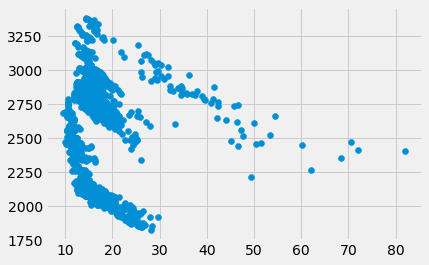

In [108]:
X = ES_VX['Close Price_y'].values.reshape(-1, 1)
Y = ES_VX['Close Price_x'].values.reshape(-1, 1)
linear_regressor = LinearRegression().fit(X, Y)  
plt.scatter(X, Y)
plt.show()

##### Prediction

As a final thought, I foresee that the current trend (higher equity/lower volatility) will persist until the ratio reaches the 200-day moving average (orange). Any pullback in the ESc1/VXc1 is an opportunity to buy more equities until that ratio becomes overbought again, which may take many more months. 

Good luck in the market! 
Guillaume, Fierce Research